# NFL Big Data Bowl 2023 
This notebook provides all of the code used to produce the results discussed in the Kaggle Notebook

In [2]:
#pip install celluloid
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from datetime import datetime
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from datetime import datetime
from datetime import timedelta

## Data Loading

In [ ]:
play_data = pd.DataFrame()
for i in range(1,9):
    loaded_data = pd.read_csv(f'week{i}.csv')
    play_data = play_data.append(loaded_data)
# DataFrame that has already been preprocessed

In [3]:
plays = pd.read_csv('plays.csv')
games = pd.read_csv('games.csv')
final_df = pd.read_csv('nflPlayData.csv') # Data Alrerady Processed
players = pd.read_csv('players.csv')
final_df

,Unnamed: 0,gameId,playId,nflId,circle_time,frameId,QBCircle,pff_role,pff_positionLinedUp,pff_hit,...,playDirection,x,y,s,a,dis,o,dir,event,time_string
0,0,2021090900,97,25511,3.8,1,1,Pass,QB,NaN,...,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,00:26:31.100
1,1,2021090900,97,25511,3.8,2,1,Pass,QB,NaN,...,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,00:26:31.200
2,2,2021090900,97,25511,3.8,3,1,Pass,QB,NaN,...,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,00:26:31.300
3,3,2021090900,97,25511,3.8,4,1,Pass,QB,NaN,...,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,00:26:31.400
4,4,2021090900,97,25511,3.8,5,1,Pass,QB,NaN,...,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,00:26:31.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7952687,7952687,2021110100,4433,53449,0.0,54,0,Pass Route,LWR,NaN,...,right,49.44,48.85,1.43,3.20,0.14,270.45,2.03,None,03:20:26.500
7952688,7952688,2021110100,4433,53449,0.0,55,0,Pass Route,LWR,NaN,...,right,49.43,48.99,1.34,2.85,0.13,273.20,349.13,None,03:20:26.600
7952689,7952689,2021110100,4433,53449,0.0,56,0,Pass Route,LWR,NaN,...,right,49.40,49.11,1.32,2.42,0.13,275.46,338.05,None,03:20:26.700
7952690,7952690,2021110100,4433,53449,0.0,57,0,Pass Route,LWR,NaN,...,right,49.33,49.22,1.29,2.18,0.13,277.09,326.21,None,03:20:26.800


# Data Preprocessing Functions

In [8]:
def total_distance_covered(df): # gets the total amount of distance a player traveled for each play
    play_ids = set(df.playId)
    players = {play_id : {} for play_id in play_ids}
    total_yards_list = []
    for play_id in play_ids:
        play = df[df['playId'] == play_id].dropna()
        for player_id in set(play['nflId']):
            player_data = play[play['nflId'] == float(player_id)].reset_index()
            snap = player_data[player_data['event'] == 'ball_snap'].index[0]
            throw = player_data[player_data['event'].isin(['run', 'qb_sack', 'pass_forward', 'autoevent_passforward', 'qb_strip_sack'])].index[0]
            total_yards = sum(player_data[snap:throw+1]['dis'])
            players[play_id][player_id] = total_yards
    return players

In [ ]:
PFF = pd.read_csv('pffScoutingData.csv')
week_1_merged = pd.merge(PFF, week1_merged, on = ['gameId', 'nflId', 'playId'])

Getting the win percentage for a team through 8 games. Taken from https://www.espn.com/nfl/scoreboard/_/week/8/year/2021/seasontype/2

In [4]:
team_wins = {team : '' for team in np.unique(final_df.team)} # The team win percentage after 8 weeks. Used as a feature in the model 
team_wins['ARI'] = 0.875
team_wins['GB'] = 0.875
team_wins['SF'] = 0.429
team_wins['CHI'] = 0.375
team_wins['NE'] = 0.500
team_wins['CAR'] = 0.500
team_wins['ATL'] = 0.429
team_wins['MIA'] = 0.125
team_wins['BUF'] = 0.714
team_wins['PIT'] = 0.571
team_wins['CLE'] = 0.500
team_wins['PHI'] = 0.375
team_wins['DET'] = 0.000
team_wins['TEN'] = 0.75
team_wins['IND'] = 0.375
team_wins['CIN'] = 0.625
team_wins['NYJ'] = 0.286
team_wins['LAC'] = 0.571
team_wins['LA'] = 0.875
team_wins['HOU'] = 0.125
team_wins['JAX'] = 0.143
team_wins['SEA'] = 0.375
team_wins['WAS'] = 0.25
team_wins['DEN'] = 0.500
team_wins['TB'] = 0.75
team_wins['NO'] = 0.714
team_wins['DAL'] = 0.857
team_wins['MIN'] = 0.429
team_wins['NYG'] = 0.25
team_wins['KC'] = 0.500
team_wins['BAL'] = 0.714
team_wins['LV'] = 0.714
team_wins_map = team_wins

# Bounding Box Work

In [5]:
def bounding_box_size(frame_info):
    """Gets the size of the bounding box for each frame"""
    linemen = frame_info[(frame_info['pff_positionLinedUp'].isin(['C', 'LT', 'RT', 'RG', 'LG']))]
    if len(linemen) != 5: # for when there is incomplete info for a lineman
        height = 0
        width = 0
        return height, width
    elif len(linemen) == 5:
        top = np.max(linemen.y) 
        bottom = np.min(linemen.y)
        left = np.min(linemen.x)
        right = np.max(linemen.x) 
        height = top - bottom 
        width = right - left 
        return height, width

In [6]:
# gets the bounding box for each play
from tqdm import tqdm
game_ids =[]
play_ids = []
frame_ids = []
heights = []
widths = []
for game_id in tqdm(np.unique(final_df.gameId)):
    game_info = final_df[final_df['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        for frame_id in np.unique(play_info.frameId):
            frame_info = play_info[play_info['frameId'] == frame_id]
            height, width = bounding_box_size(frame_info)
            game_ids.append(game_id)
            play_ids.append(play_id)
            frame_ids.append(frame_id)
            heights.append(height)
            widths.append(width)
bounding_box_df = pd.DataFrame({'gameId' : game_ids, 'playId' : play_ids, 'frameId' : frame_ids, 'height' : heights, 'width' : widths})
bounding_box_df['area'] = [height * width for height, width in zip(bounding_box_df['height'], bounding_box_df['width'])]
bounding_box_df

100%|██████████| 122/122 [01:49<00:00,  1.12it/s]


,gameId,playId,frameId,height,width,area
0,2021090900,97,1,5.53,1.03,5.6959
1,2021090900,97,2,5.52,1.02,5.6304
2,2021090900,97,3,5.53,1.01,5.5853
3,2021090900,97,4,5.54,1.01,5.5954
4,2021090900,97,5,5.57,1.01,5.6257
...,...,...,...,...,...,...
361481,2021110100,4433,54,5.79,4.16,24.0864
361482,2021110100,4433,55,5.87,4.30,25.2410
361483,2021110100,4433,56,5.93,4.40,26.0920
361484,2021110100,4433,57,6.02,4.46,26.8492


In [7]:
game_ids = [] # The average box dimensions for the last second
play_ids = []
avg_heights = []
avg_widths = []
avg_areas = []
for game_id in np.unique(bounding_box_df.gameId):
    game_info = bounding_box_df[bounding_box_df['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        last_second = play_info.tail(10)
        game_ids.append(game_id)
        play_ids.append(play_id)
        avg_heights.append(last_second.height.mean())
        avg_widths.append(last_second.width.mean())
        avg_areas.append(last_second.area.mean())
bounding_box_averages = pd.DataFrame({'gameId': game_ids, 'playId' : play_ids, 'avg_height' :avg_heights, 'avg_width' : avg_widths, 'avg_area' : avg_areas })
bounding_box_averages

,gameId,playId,avg_height,avg_width,avg_area
0,2021090900,97,5.876,5.274,31.58938
1,2021090900,137,6.961,2.536,17.41961
2,2021090900,187,5.654,0.580,3.29524
3,2021090900,282,4.942,3.231,16.23850
4,2021090900,349,4.824,3.864,18.41662
...,...,...,...,...,...
8552,2021110100,4310,15.813,6.451,102.26352
8553,2021110100,4363,5.694,3.524,20.20878
8554,2021110100,4392,6.982,3.717,25.96863
8555,2021110100,4411,5.571,5.260,28.94771


# Plotting a Play

In [758]:
def get_circle_points(x,y,radius): # Used to get the points that make up the QB cirlce for each play
    Xs = []
    Ys = []
    for angle in range(360):
        X = x + radius  * np.cos(angle)
        Y = y + radius * np.sin(angle)
        Xs.append(X)
        Ys.append(Y)
    return Xs, Ys

In [759]:
teams_color_dict = {team : '' for team in np.unique(final_df.team)}
teams_color_dict['ARI'] = ['red', 'black']
teams_color_dict['ATL'] = ['red', 'black']
teams_color_dict['BAL'] = ['purple', 'black']
teams_color_dict['BUF'] = ['red', 'blue']
teams_color_dict['CAR'] = ['deepskyblue', 'black']
teams_color_dict['CHI'] = ['blue', 'darkred']
teams_color_dict['CIN'] = ['orange', 'black']
teams_color_dict['CLE'] = ['brown', 'orange']
teams_color_dict['DAL'] = ['grey', 'blue']
teams_color_dict['DEN'] = ['orange', 'blue']
teams_color_dict['DET'] = ['blue', 'grey']
teams_color_dict['GB'] = ['green', 'yellow']
teams_color_dict['HOU'] = ['blue', 'red']
teams_color_dict['IND'] = ['blue', 'grey']
teams_color_dict['JAX'] = ['olive', 'yellow']
teams_color_dict['KC'] = ['red', 'yellow']
teams_color_dict['LA'] = ['blue', 'yellow']
teams_color_dict['LAC'] = ['deepskyblue', 'yellow']
teams_color_dict['LV'] = ['black', 'grey']
teams_color_dict['MIA'] = ['turquoise', 'yellow']
teams_color_dict['MIN'] = ['purple', 'yellow']
teams_color_dict['NE'] = ['grey', 'red']
teams_color_dict['NO'] = ['black', 'gold']
teams_color_dict['NYG'] = ['blue', 'red']
teams_color_dict['NYJ'] = ['green', 'black']
teams_color_dict['PHI'] = ['darkgreen', 'grey']
teams_color_dict['PIT'] = ['yellow', 'black']
teams_color_dict['SEA'] = ['darkblue', 'grey']
teams_color_dict['TB'] = ['red', 'black']
teams_color_dict['SF'] = ['maroon', 'gold']
teams_color_dict['TEN'] = ['steelblue', 'grey']
teams_color_dict['WAS'] = ['darkred', 'yellow']

In [8]:
def get_distances(play_info):
    # gets the distance of the gap between linemen
    C = play_info[play_info['pff_positionLinedUp'] == 'C']
    LT = play_info[play_info['pff_positionLinedUp'] == 'LT']
    RT = play_info[play_info['pff_positionLinedUp'] == 'RT']
    LG = play_info[play_info['pff_positionLinedUp'] == 'LG']
    RG = play_info[play_info['pff_positionLinedUp'] == 'RG']
    # getting the size of the gaps between the linemen
    gap1 = math.dist([C.iloc[0].x, C.iloc[0].y], [LG.iloc[0].x, LG.iloc[0].y])
    gap2 = math.dist([C.iloc[0].x, C.iloc[0].y], [RG.iloc[0].x, RG.iloc[0].y])
    gap3 = math.dist([LG.iloc[0].x, LG.iloc[0].y], [LT.iloc[0].x, LT.iloc[0].y])
    gap4 = math.dist([RG.iloc[0].x, RG.iloc[0].y], [RT.iloc[0].x, RT.iloc[0].y])
    distances = [gap1,gap2,gap3,gap4]
    average_dist = np.average(distances)
    return average_dist

In [770]:
from celluloid import Camera
from  matplotlib.patches import Rectangle

def plot_play(play_data, cirlce_radius, file_name):
    dist_avg = round(np.average(average_density.avg_dist),2)
    dist_max = round(np.max(average_density.avg_dist),2)
    dist_min = round(np.min(average_density.avg_dist),2)
    fig, axs = plt.subplots()
    camera = Camera(fig)
    for i in range(len(play_data[play_data['nflId'] == np.unique(play_data.nflId)[0]])):
        frame_info = play_data[play_data['frameId'] == i +1]
        linemen = frame_info[(frame_info['pff_positionLinedUp'].isin(['C', 'LT', 'RT', 'RG', 'LG']))]
        top = np.max(linemen.y) +1
        bottom = np.min(linemen.y)
        left = np.min(linemen.x)
        right = np.max(linemen.x) +1
        height = top - bottom + 1
        width = right - left + 1
        axs.add_patch(Rectangle((left -1  ,bottom -1 ), width , height))
        for player_id in np.unique(play_data['nflId']):
            player_data = play_data[play_data['nflId'] == player_id ]
            qb_color = False
            lineman = False
            if (player_data['pff_positionLinedUp'].iloc[i] == 'QB'):
                player_team = player_data.iloc[i]['team']
                qb_color = teams_color_dict[player_team][1]
                Xs, Ys = get_circle_points(player_data.x.iloc[i], player_data.y.iloc[i], cirlce_radius)
                [axs.plot(x,y, marker = ',', color = 'black') for x,y in zip(Xs,Ys)]
            elif (player_data['pff_positionLinedUp'].iloc[0] in ['C', 'LT', 'RT', 'RG', 'LG']):
                lineman = True
            player_team = player_data.iloc[i]['team']
            if qb_color:
                Color = qb_color
            elif lineman:
                Color = teams_color_dict[player_team][1]
            else:
                Color = teams_color_dict[player_team][0]
            axs.plot(player_data.x.iloc[i], player_data.y.iloc[i], marker = 'o', color = Color)
            #frame_info = play_data[play_data['frameId' == i]]
            axs.text(17,47,f'Average Distance Between Linemen (yards): {round(get_distances(frame_info),2)}', size = 12)
            axs.text(17,44.5,f'Min Dis: {dist_min}, Max Dis: {dist_max}, Total Avg. Dis: {dist_avg}', size = 12)
            [axs.vlines(x, 0, 45, linestyles= 'dashed', colors= 'black') for x in [20,30,40]]


        camera.snap()
    animation = camera.animate()
    animation.save(file_name)


In [771]:
pats_play = final_df[(final_df.gameId == 2021091210) & (final_df.playId == 146)]

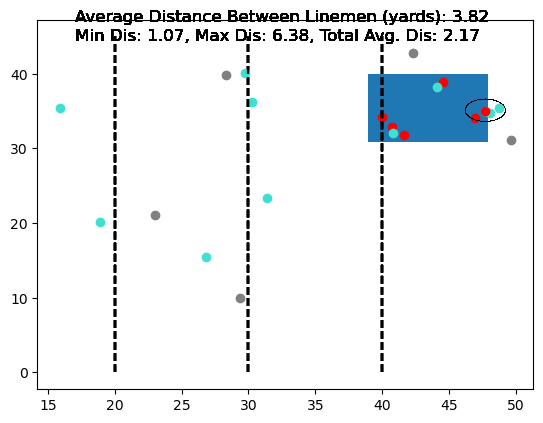

In [772]:
plot_play(pats_play, 1.5, 'patriots_example.gif')

# QB Circle Approach

In [9]:
def get_circle_locations(df, circle_radius):
    play_ids = []
    circle_points = []
    frame_ids  = []
    game_ids = []
    for game_id in np.unique(df['gameId']):
        game_info = df[df['gameId'] == int(game_id)]
        for play_id in np.unique(game_info.playId):
            play_info = game_info[game_info['playId'] == play_id]
            for frame_id in np.unique(play_info.frameId):
                frame = play_info[(play_info['frameId'] == frame_id) & (play_info['pff_positionLinedUp'] == 'QB')]
                points = get_circle_points(frame.iloc[0]['x'], frame.iloc[0]['y'], circle_radius)
                frame_ids.append(frame_id)
                circle_points.append(points)
                play_ids.append(play_id)
                game_ids.append(game_id)
    qb_location = pd.DataFrame({'gameId': game_ids, 'playId' : play_ids, 'frameId' : frame_ids, 'circle_points' : circle_points})
    return qb_location

In [10]:
def qb_circle_status(df): #Detects if the player is within the QB circle during a given time
    plays_dict = {game_id : {} for game_id in np.unique(df.gameId)}
    for game_id in tqdm(np.unique(df['gameId'])):
        game_info = df[df['gameId'] == int(game_id)]
        for play_id in np.unique(game_info.playId):
            plays_dict[game_id][play_id] = {}
            play_info = game_info[game_info['playId'] == play_id]
            plays_dict[play_id] = {}
            for frame_id in np.unique(play_info.frameId):
                plays_dict[game_id][play_id][frame_id] = {}
                frame_info = play_info[play_info['frameId'] == frame_id]
                qb_info = frame_info[frame_info['pff_positionLinedUp'] == 'QB'].iloc[0]
                qb_location = [qb_info.x, qb_info.y]
                zone_status = []
                player_ids = []
                for player_id in np.unique(frame_info.nflId):
                    player_info = frame_info[frame_info['nflId'] == player_id]
                    defender_in_zone = 0
                    x = player_info['x']
                    y = player_info['y']
                    distance_from_qb = math.dist(qb_location, [x,y])
                    if distance_from_qb <= 2.75:
                        defender_in_zone = 1
                    zone_status.append(defender_in_zone)
                    player_ids.append(player_id)
                plays_dict[game_id][play_id][frame_id]['player_ids'] = player_ids
                plays_dict[game_id][play_id][frame_id]['zone_status'] = zone_status
    return plays_dict
qb_circle_dict = qb_circle_status(week_1_merged)

In [ ]:
game_ids_list = []
play_ids_list = []
frame_ids_list = []
frame_data = []
playerIDS = []
for game_id in np.unique(week_1_merged['gameId']):
    game_dict = qb_circle_dict[game_id]
    for play_id in list(game_dict.keys()):
        play_info = game_dict[play_id]
        for frame in list(play_info.keys()):
            frame_info = play_info[frame]['zone_status']
            player_ids = play_info[frame]['player_ids']
            for i in range(len(frame_info)):
                game_ids_list.append(game_id)
            for i in range(len(frame_info)):
                play_ids_list.append(play_id)
            for i in range(len(frame_info)):
                frame_ids_list.append(frame)
            for i in frame_info:
                frame_data.append(i)
            for i in player_ids:
                playerIDS.append(i)

In [ ]:
qb_circle_status_df = pd.DataFrame({'gameId':  game_ids_list, 'playId' : play_ids_list, 'frameId' : frame_ids_list, 'nflId' : playerIDS, 'QBCircle' : frame_data})
final_df = pd.merge(qb_circle_status_df, week_1_merged, on = ['gameId', 'playId', 'frameId', 'nflId'])

## Getting the time in the zone

In [975]:
def time_in_circle(df): # gets the total amount of time players spent in the qb circle for a play
    game_ids_list = []
    play_ids_list = []
    times_list = []
    playerIDS = []
    # add the players that are in the zone, and then add the ones that are not in the zone, followed by a 0, using the numpy function 
    for game_id in np.unique(df.gameId):
        game_info = df[df['gameId']== game_id]
        for play_id in np.unique(game_info.playId):
            play_info = game_info[game_info['playId'] == play_id]
            #time_dict = {player_id: 0 for player_id in np.unique(play_info['nflId'])}
            try:
                play_start = play_info[play_info['event'] == 'ball_snap']
                snap_time = play_start.time_string.iloc[0]
            except IndexError:
                #time_dict = {player_id: 0 for player_id in np.unique(play_info['nflId'])}
                for i in range(len(np.unique(play_info['nflId']))):
                    game_ids_list.append(game_id)
                    play_ids_list.append(play_id)
                    times_list.append(0)
                for i in np.unique(play_info['nflId']):
                    playerIDS.append(i)
                continue
            #print(game_id,play_id)
            snap_time = play_start.time_string.iloc[0]
            snap_time = datetime.strptime(snap_time, '%H:%M:%S.%f')
            event_time = play_info[play_info['event'].isin(['run', 'qb_sack', 'pass_forward', 'autoevent_passforward', 'qb_strip_sack'])].iloc[0]['time_string']
            in_zone_info = play_info[play_info['QBCircle'] == 1]
            for player_id in np.unique(in_zone_info.nflId):
                play_times = pd.to_datetime(in_zone_info[in_zone_info['nflId'] == player_id].time_string, format=  '%H:%M:%S.%f')
                time_in_zone = len(np.where((play_times <= event_time) & (play_times >= snap_time))[0]) * 0.1
                game_ids_list.append(game_id)
                play_ids_list.append(play_id)
                playerIDS.append(player_id)
                times_list.append(time_in_zone)
            all_players = np.unique(play_info['nflId'])
            non_zone_players = all_players[np.isin(all_players, np.unique(in_zone_info.nflId), invert = True)]
            for player_id in non_zone_players:
                game_ids_list.append(game_id)
                play_ids_list.append(play_id)
                playerIDS.append(player_id)
                times_list.append(0)
    return pd.DataFrame({'gameId' : game_ids_list, 'playId' : play_ids_list, 'nflId' : playerIDS, 'circle_time' : times_list})

In [ ]:
circle_time = time_in_circle(final_df)
final_df = pd.merge(circle_time, final_df)

## Density of Linemen Approach

Using the approach of getting the average distance (Or density) of the linemen during a specific play.

In [13]:
def get_line_distances(play_info): # gets the average distance between linemen for a play
    avg_distances = []
    for frame in np.unique(play_info.frameId):
        frame_info = play_info[play_info['frameId'] == frame]
        C = frame_info[frame_info['pff_positionLinedUp'] == 'C']
        LT = frame_info[frame_info['pff_positionLinedUp'] == 'LT']
        RT = frame_info[frame_info['pff_positionLinedUp'] == 'RT']
        LG = frame_info[frame_info['pff_positionLinedUp'] == 'LG']
        RG = frame_info[frame_info['pff_positionLinedUp'] == 'RG']
        distances = []
        # getting the size of the gaps between the linemen
        try:
            gap1 = math.dist([C.iloc[0].x, C.iloc[0].y], [LG.iloc[0].x, LG.iloc[0].y])
            distances.append(gap1)
            gap2 = math.dist([C.iloc[0].x, C.iloc[0].y], [RG.iloc[0].x, RG.iloc[0].y])
            distances.append(gap2)
            gap3 = math.dist([LG.iloc[0].x, LG.iloc[0].y], [LT.iloc[0].x, LT.iloc[0].y])
            distances.append(gap3)
            gap4 = math.dist([RG.iloc[0].x, RG.iloc[0].y], [RT.iloc[0].x, RT.iloc[0].y])
            distances.append(gap4)
        except IndexError:
            avg_distances.append(0)
            continue
        average_dist = np.average(distances)
        avg_distances.append(average_dist)
    return avg_distances


In [14]:
# scaling up for all games
from tqdm import tqdm
df = final_df
game_ids = np.unique(df.gameId)
distance_info = {game_id : {} for game_id in game_ids}
for game_id in tqdm(game_ids):
    game_info = df[df['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        avg_distance = round(np.average(get_line_distances(play_info)),3)
        distance_info[game_id][play_id] = avg_distance
    

100%|██████████| 122/122 [07:00<00:00,  3.45s/it]


In [15]:
game_ids =[]
distances = []
play_ids = []
for game_id in list(distance_info.keys()):
    game_info = distance_info[game_id]
    for play_id in list(game_info.keys()):
        play_ids.append(play_id)
        distances.append(game_info[play_id])
        game_ids.append(game_id)

In [16]:
average_density = pd.DataFrame({'gameId' : game_ids, 'playId' : play_ids, 'avg_dist' : distances})
average_density.drop(index = list(average_density[average_density['avg_dist'] == 0].index), inplace = True)
density_merged = pd.merge(final_df, average_density, on = ['gameId', 'playId'])

In [17]:
distances = []
play_ids =[]
game_ids = []
outcomes = []
time_to_throw = []
status = []
for game_id in tqdm(np.unique(density_merged.gameId)):
    game_info = density_merged[density_merged['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id].iloc[0]
        if 1 in [play_info['pff_hitAllowed'],play_info['pff_hurryAllowed'],play_info['pff_sackAllowed']]:
            status.append(1)
        else:
            status.append(0)

        avg_density = play_info.avg_dist
        distances.append(avg_density)
        play_ids.append(play_id)
        game_ids.append(game_id)
        outcomes.append(play_info.play_outcome)
        time_to_throw.append(play_info.time_to_throw)
    

100%|██████████| 122/122 [00:05<00:00, 21.85it/s]


In [18]:
further_defensive_info = plays[['gameId', 'playId', 'gameClock','offenseFormation',  'dropBackType', 'pff_playAction', 'defendersInBox', 'pff_passCoverage']]
further_defensive_info

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage
0,2021090900,97,13:33,SHOTGUN,TRADITIONAL,0,6.0,Cover-1
1,2021090900,137,13:18,EMPTY,TRADITIONAL,0,6.0,Cover-3
2,2021090900,187,12:23,SHOTGUN,TRADITIONAL,0,6.0,Cover-3
3,2021090900,282,09:56,SINGLEBACK,TRADITIONAL,1,6.0,Cover-3
4,2021090900,349,09:46,SHOTGUN,TRADITIONAL,0,7.0,Cover-3
...,...,...,...,...,...,...,...,...
8552,2021110100,4310,01:56,SHOTGUN,SCRAMBLE,0,4.0,Bracket
8553,2021110100,4363,01:07,SHOTGUN,SCRAMBLE,0,5.0,Cover-2
8554,2021110100,4392,01:01,SHOTGUN,TRADITIONAL,0,6.0,Cover-2
8555,2021110100,4411,00:39,SHOTGUN,TRADITIONAL,0,5.0,Cover-2


# Baseline Models

In [19]:
# reducing the size of the dataset to only look at the offensive linemen
linemen = density_merged[density_merged['pff_positionLinedUp'].isin(['LT', 'LG', 'C', 'RT', 'RG'])]

In [20]:
# creating a summary DataFrame for each play
distances = []
play_ids =[]
game_ids = []
outcomes = []
time_to_throw = []
status = []
circle_times = []
team_win_percentages = []
linemen = density_merged[density_merged['pff_positionLinedUp'].isin(['LT', 'LG', 'C', 'RT', 'RG'])]
for game_id in tqdm(np.unique(linemen.gameId)):
    game_info = linemen[linemen['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        if (1 in np.array(play_info['pff_hitAllowed'])) or (1 in np.array(play_info['pff_hurryAllowed'])) or ( 1 in np.array(play_info['pff_sackAllowed'])):
            status.append(0)
        else:
            status.append(1)

        avg_density = play_info.iloc[0].avg_dist
        distances.append(avg_density)
        play_ids.append(play_id)
        game_ids.append(game_id)
        outcomes.append(play_info.iloc[0].play_outcome)
        circle_times.append(play_info.iloc[0].circle_time)
        time_to_throw.append(play_info.iloc[0].time_to_throw)
        team = play_info.iloc[0].team
        team_win_percentages.append(team_wins_map[team])

play_summary_df = pd.DataFrame({'gameId': game_ids, 'playId' : play_ids, 'distances' : distances, 'time_to_throw': time_to_throw, 'outcomes' : outcomes, 'event_allowed' : status,
'total_circle_time' :circle_times, 'team_win_percentage' : team_win_percentages})
play_summary_df['sacked'] = [0 if i in ['pass_forward', 'autoevent_passforward'] else 1 if i in ['qb_sack', 'qb_strip_sack'] else 2 for i in play_summary_df.outcomes]
play_summary_df

100%|██████████| 122/122 [00:03<00:00, 35.25it/s]


,gameId,playId,distances,time_to_throw,outcomes,event_allowed,total_circle_time,team_win_percentage,sacked
0,2021090900,97,2.588,3.2,autoevent_passforward,0,0.6,0.750,0
1,2021090900,137,1.906,2.5,pass_forward,1,0.7,0.857,0
2,2021090900,187,1.581,2.0,autoevent_passforward,1,0.0,0.857,0
3,2021090900,282,1.579,3.2,pass_forward,1,0.6,0.857,0
4,2021090900,349,1.951,2.5,autoevent_passforward,1,0.9,0.857,0
...,...,...,...,...,...,...,...,...,...
8550,2021110100,4310,3.624,4.8,qb_sack,1,0.6,0.500,1
8551,2021110100,4363,1.965,3.6,autoevent_passforward,0,1.4,0.250,0
8552,2021110100,4392,2.252,4.1,qb_sack,0,0.4,0.250,1
8553,2021110100,4411,2.125,2.5,autoevent_passforward,0,0.3,0.250,0


In [21]:
status = []
for event, sacked in zip(play_summary_df.event_allowed, play_summary_df.sacked):
    if (sacked == 1) and (event ==1):
        status.append(0)
    else:
        status.append(event)
play_summary_df['event_allowed'] = status
play_summary_df.head()

,gameId,playId,distances,time_to_throw,outcomes,event_allowed,total_circle_time,team_win_percentage,sacked
0,2021090900,97,2.588,3.2,autoevent_passforward,0,0.6,0.750,0
1,2021090900,137,1.906,2.5,pass_forward,1,0.7,0.857,0
2,2021090900,187,1.581,2.0,autoevent_passforward,1,0.0,0.857,0
3,2021090900,282,1.579,3.2,pass_forward,1,0.6,0.857,0
4,2021090900,349,1.951,2.5,autoevent_passforward,1,0.9,0.857,0


## Model Data Preprocessing (Split, etc.)

In [235]:
# adding polynomial features to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_train_transformed_unbalanced = pd.DataFrame(poly.fit_transform(np.array(valid_plays_unbalanced[['offenseFormation','team_win_percentage','dropBackType', 'distances', 'defendersInBox', 'height', 'width', 'time_to_throw','total_circle_time']])))
X_train_transformed_unbalanced['event_allowed'] = np.array(valid_plays_unbalanced.event_allowed)
X_train_transformed_balanced = pd.DataFrame(poly.fit_transform(np.array(valid_plays_balanced[['offenseFormation','team_win_percentage','dropBackType', 'distances', 'defendersInBox', 'height', 'width', 'time_to_throw','total_circle_time']])))
X_train_transformed_balanced['event_allowed'] = np.array(valid_plays_balanced.event_allowed)

## Final Modeling DataFrame

In [22]:
play_features_df = pd.merge(play_summary_df,bounding_box_averages, on = ['gameId', 'playId'])
play_features_df = play_features_df[play_features_df['sacked'].isin([0,1])] # gets rid of runs
play_features_df = pd.merge(further_defensive_info,play_features_df, on = ['gameId', 'playId'])
from sklearn import preprocessing
for column in ['offenseFormation', 'dropBackType', 'pff_passCoverage']:
    encoder = preprocessing.LabelEncoder()
    encoder.fit(play_features_df[column])
    play_features_df[column] = encoder.transform(play_features_df[column])
play_features_df.defendersInBox.fillna(play_features_df.defendersInBox.mean(),inplace= True)
play_features_df

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,outcomes,event_allowed,total_circle_time,team_win_percentage,sacked,avg_height,avg_width,avg_area
0,2021090900,97,13:33,4,5,0,6.0,3,2.588,3.2,autoevent_passforward,0,0.6,0.750,0,5.876,5.274,31.58938
1,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,pass_forward,1,0.7,0.857,0,6.961,2.536,17.41961
2,2021090900,187,12:23,4,5,0,6.0,5,1.581,2.0,autoevent_passforward,1,0.0,0.857,0,5.654,0.580,3.29524
3,2021090900,282,09:56,5,5,1,6.0,5,1.579,3.2,pass_forward,1,0.6,0.857,0,4.942,3.231,16.23850
4,2021090900,349,09:46,4,5,0,7.0,5,1.951,2.5,autoevent_passforward,1,0.9,0.857,0,4.824,3.864,18.41662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8058,2021110100,4310,01:56,4,2,0,4.0,1,3.624,4.8,qb_sack,0,0.6,0.500,1,15.813,6.451,102.26352
8059,2021110100,4363,01:07,4,2,0,5.0,4,1.965,3.6,autoevent_passforward,0,1.4,0.250,0,5.694,3.524,20.20878
8060,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,qb_sack,0,0.4,0.250,1,6.982,3.717,25.96863
8061,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,autoevent_passforward,0,0.3,0.250,0,5.571,5.260,28.94771


In [23]:
play_features_df['play_id'] = range(len(play_features_df))
week_info = games[['gameId', 'week']]
play_features_df = pd.merge(play_features_df, week_info)
team_game_map = plays[['gameId', 'playId', 'possessionTeam', 'defensiveTeam', 'quarter', 'down', 'yardsToGo', 'playResult', 'absoluteYardlineNumber' ]]
play_features_df = pd.merge(play_features_df, team_game_map, on = ['gameId', 'playId'])
play_features_df

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,avg_area,play_id,week,possessionTeam,defensiveTeam,quarter,down,yardsToGo,playResult,absoluteYardlineNumber
0,2021090900,97,13:33,4,5,0,6.0,3,2.588,3.2,...,31.58938,0,1,TB,DAL,1,3,2,0,43.0
1,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,...,17.41961,1,1,DAL,TB,1,1,10,28,108.0
2,2021090900,187,12:23,4,5,0,6.0,5,1.581,2.0,...,3.29524,2,1,DAL,TB,1,2,6,5,76.0
3,2021090900,282,09:56,5,5,1,6.0,5,1.579,3.2,...,16.23850,3,1,DAL,TB,1,1,10,0,49.0
4,2021090900,349,09:46,4,5,0,7.0,5,1.951,2.5,...,18.41662,4,1,DAL,TB,1,3,15,0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8058,2021110100,4310,01:56,4,2,0,4.0,1,3.624,4.8,...,102.26352,8058,8,KC,NYG,4,3,8,-8,18.0
8059,2021110100,4363,01:07,4,2,0,5.0,4,1.965,3.6,...,20.20878,8059,8,NYG,KC,4,1,10,3,35.0
8060,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,...,25.96863,8060,8,NYG,KC,4,2,7,-8,38.0
8061,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,...,28.94771,8061,8,NYG,KC,4,3,15,0,30.0


In [ ]:
new_final_df = pd.DataFrame()
for game_id in np.unique(play_features_df.gameId):
    game_info = play_features_df[play_features_df['gameId'] == game_id]
    for team in np.unique(game_info['possessionTeam']):
        team_plays = game_info[game_info['possessionTeam'] == team]
        sorted_plays = team_plays.sort_values(by = ['week', 'quarter'])
        sorted_plays = sorted_plays.sort_values(by = ['gameClock'], ascending = False)
        clean_throws = 0
        eventful_throws = 0 # these are the ones where the qb was hit, hurried or sacked
        clean_throws_list = []
        eventful_throws_list = []
        for i in range(len(sorted_plays)): # all of the plays for one team for a game
            play_info = sorted_plays.iloc[i]
            throw_status = play_info.event_allowed
            if throw_status == 1:
                clean_throws += 1
                clean_throws_list.append(clean_throws)
                eventful_throws_list.append(eventful_throws)
            elif throw_status == 0:
                eventful_throws += 1
                eventful_throws_list.append(eventful_throws)
                clean_throws_list.append(clean_throws)
        sorted_plays['succseful_ratio'] = list(clean_throws_list) / (np.array(clean_throws_list) + np.array(eventful_throws_list))
        new_final_df = new_final_df.append(sorted_plays)
new_final_df

In [25]:
play_features_df = new_final_df
play_features_df['unsuccseful_ratio'] = 1- play_features_df['succseful_ratio'] 
play_features_df

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,week,possessionTeam,defensiveTeam,quarter,down,yardsToGo,playResult,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio
47,2021090900,2530,14:57,4,5,0,6.0,4,1.508,2.3,...,1,DAL,TB,3,2,10,5,35.0,1.000000,0.000000
48,2021090900,2554,14:27,4,5,0,7.0,5,1.512,2.1,...,1,DAL,TB,3,3,5,16,40.0,1.000000,0.000000
19,2021090900,1078,14:21,4,5,0,5.0,10,1.871,2.7,...,1,DAL,TB,2,2,8,5,17.0,1.000000,0.000000
1,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,...,1,DAL,TB,1,1,10,28,108.0,1.000000,0.000000
49,2021090900,2632,12:44,4,5,0,6.0,1,2.077,2.9,...,1,DAL,TB,3,3,4,14,62.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,...,8,NYG,KC,4,2,7,-8,38.0,0.760000,0.240000
8061,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,...,8,NYG,KC,4,3,15,0,30.0,0.730769,0.269231
8062,2021110100,4433,00:35,4,5,0,6.0,10,2.364,4.6,...,8,NYG,KC,4,4,15,-5,30.0,0.703704,0.296296
8027,2021110100,2165,00:25,4,6,0,6.0,3,1.742,2.6,...,8,NYG,KC,2,1,10,8,47.0,0.714286,0.285714


## Final Model Building


In [26]:
encoder = preprocessing.LabelEncoder()
encoder.fit(play_features_df['possessionTeam'])
encoder.fit(play_features_df['defensiveTeam'])
play_features_df['possessionTeam_encoded'] = encoder.transform(play_features_df['possessionTeam'])
play_features_df['defensiveTeam_encoded'] = encoder.transform(play_features_df['defensiveTeam'])
play_features_df

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,defensiveTeam,quarter,down,yardsToGo,playResult,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio,possessionTeam_encoded,defensiveTeam_encoded
47,2021090900,2530,14:57,4,5,0,6.0,4,1.508,2.3,...,TB,3,2,10,5,35.0,1.000000,0.000000,8,29
48,2021090900,2554,14:27,4,5,0,7.0,5,1.512,2.1,...,TB,3,3,5,16,40.0,1.000000,0.000000,8,29
19,2021090900,1078,14:21,4,5,0,5.0,10,1.871,2.7,...,TB,2,2,8,5,17.0,1.000000,0.000000,8,29
1,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,...,TB,1,1,10,28,108.0,1.000000,0.000000,8,29
49,2021090900,2632,12:44,4,5,0,6.0,1,2.077,2.9,...,TB,3,3,4,14,62.0,1.000000,0.000000,8,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,...,KC,4,2,7,-8,38.0,0.760000,0.240000,23,15
8061,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,...,KC,4,3,15,0,30.0,0.730769,0.269231,23,15
8062,2021110100,4433,00:35,4,5,0,6.0,10,2.364,4.6,...,KC,4,4,15,-5,30.0,0.703704,0.296296,23,15
8027,2021110100,2165,00:25,4,6,0,6.0,3,1.742,2.6,...,KC,2,1,10,8,47.0,0.714286,0.285714,23,15


In [723]:
play_features_df_final = pd.merge(play_features_df, throws_ratio, on = ['gameId', 'possessionTeam', 'quarter'])
play_features_df_final

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,quarter,down,yardsToGo,playResult,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio,possessionTeam_encoded,defensiveTeam_encoded,ratio
0,2021090900,2530,14:57,4,5,0,6.0,4,1.508,2.3,...,3,2,10,5,35.0,1.000000,0.000000,8,29,0.785714
1,2021090900,2554,14:27,4,5,0,7.0,5,1.512,2.1,...,3,3,5,16,40.0,1.000000,0.000000,8,29,0.785714
2,2021090900,2632,12:44,4,5,0,6.0,1,2.077,2.9,...,3,3,4,14,62.0,1.000000,0.000000,8,29,0.785714
3,2021090900,2656,12:14,4,5,0,7.0,4,1.793,1.8,...,3,1,10,0,76.0,1.000000,0.000000,8,29,0.785714
4,2021090900,2678,12:10,4,6,0,6.0,10,2.089,2.9,...,3,2,10,16,76.0,1.000000,0.000000,8,29,0.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8039,2021110100,3150,01:28,4,5,1,6.0,3,2.514,2.6,...,3,1,10,11,42.0,0.863636,0.136364,23,15,0.833333
8040,2021110100,3195,00:05,0,5,0,5.0,2,1.923,1.8,...,3,1,10,6,21.0,0.724138,0.275862,23,15,0.833333
8041,2021110100,441,07:43,4,5,0,6.0,4,2.131,1.9,...,1,2,8,0,88.0,0.777778,0.222222,23,15,1.000000
8042,2021110100,587,06:12,4,5,1,7.0,6,2.777,3.0,...,1,1,10,0,85.0,0.846154,0.153846,23,15,1.000000


In [138]:
play_features_df_final = play_features_df
training_set = play_features_df_final.sample(n = int((0.8 * len(play_features_df_final))))
test_playids = np.setdiff1d(list(range(len(play_features_df_final))),list(training_set.play_id)) # the play ids that are not in the training set
test_set = play_features_df_final[play_features_df_final.playId.isin(test_playids)]
event = training_set[training_set['event_allowed'] == 0]
no_event = training_set[training_set['event_allowed'] == 1].sample(n = len(event))
training_set = event.append(no_event)

/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_35742/1121742301.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_set = event.append(no_event)


In [139]:
print(f'Training set shape {training_set.shape}')
print(f'Test set shape {test_set.shape}')
training_set.head()

Training set shape (3470, 32)
Test set shape (1690, 32)


,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,quarter,down,yardsToGo,playResult,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio,possessionTeam_encoded,defensiveTeam_encoded,metric_score
6761,2021102406,2609,10:35,4,2,0,6.0,5,3.188,6.3,...,3,3,6,-2,73.0,0.700000,0.300000,10,16,-2.833812
7631,2021103107,3869,03:50,0,5,0,6.0,5,2.168,3.1,...,4,2,9,13,23.0,0.677419,0.322581,24,6,0.115244
3088,2021092613,2050,00:22,4,6,0,5.0,11,2.048,2.0,...,2,3,5,5,16.0,0.710526,0.289474,28,11,0.152704
5327,2021101700,142,13:23,3,5,0,6.0,5,2.082,3.6,...,1,3,9,10,36.0,0.333333,0.666667,19,14,-2.624970
966,2021091212,3410,03:09,4,5,0,6.0,11,2.188,3.8,...,4,3,10,-5,26.0,0.689655,0.310345,23,9,-2.545749


In [140]:
X = training_set[['quarter',  'offenseFormation', 'succseful_ratio','yardsToGo', 'playResult', 'absoluteYardlineNumber' ,'possessionTeam_encoded', 'defensiveTeam_encoded', 'dropBackType', 'distances', 'defendersInBox',  'avg_height', 'avg_width',  'time_to_throw','total_circle_time']]
y = training_set['event_allowed']
X_2 = test_set[['quarter', 'offenseFormation', 'succseful_ratio', 'yardsToGo', 'playResult', 'absoluteYardlineNumber',  'possessionTeam_encoded', 'defensiveTeam_encoded', 'dropBackType', 'distances', 'defendersInBox', 'avg_height',  'avg_width',  'time_to_throw','total_circle_time']]
y_2 = test_set['event_allowed']
#standardizing the inputs 
X_standardized = X / np.std(X,0)
log_reg = LogisticRegression()
log_reg_standard = LogisticRegression()
log_reg.fit(X, np.array(y))
log_reg_standard.fit(X_standardized, np.array(y))
predictions_standardized = log_reg.predict(X_2)
predictions = log_reg.predict(X_2)
print('X_train:')
display(X.head())
print(f'Accuracy Score: {round(accuracy_score(y_2, predictions_standardized),2)}')
print(f'Balanced Accuracy Score: {round(balanced_accuracy_score(y_2, predictions_standardized),2)}')
print(f'Regression Coefficients: {log_reg.coef_}')
print(f'Bias term: {log_reg.intercept_}')

X_train:


/Users/zgalante/miniforge3/envs/w207_final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,quarter,offenseFormation,succseful_ratio,yardsToGo,playResult,absoluteYardlineNumber,possessionTeam_encoded,defensiveTeam_encoded,dropBackType,distances,defendersInBox,avg_height,avg_width,time_to_throw,total_circle_time
6761,3,4,0.700000,6,-2,73.0,10,16,2,3.188,6.0,7.153,9.840,6.3,0.8
7631,4,0,0.677419,9,13,23.0,24,6,5,2.168,6.0,7.226,6.827,3.1,0.8
3088,2,4,0.710526,5,5,16.0,28,11,6,2.048,5.0,4.501,4.083,2.0,0.4
5327,1,3,0.333333,9,10,36.0,19,14,5,2.082,6.0,3.763,5.222,3.6,1.3
966,4,4,0.689655,10,-5,26.0,23,9,5,2.188,6.0,5.085,4.116,3.8,2.7


Accuracy Score: 0.79
Balanced Accuracy Score: 0.77
Regression Coefficients: [[-5.17358319e-02  6.09489069e-02  4.56390432e+00  6.39503987e-03
   3.43769627e-02 -7.27457593e-05 -6.65036000e-03 -8.28189091e-03
  -1.69875668e-01 -1.26587322e+00  9.85055821e-02  2.10603122e-01
   2.78646652e-02 -5.83276088e-01 -5.85301928e-01]]
Bias term: [0.38538333]


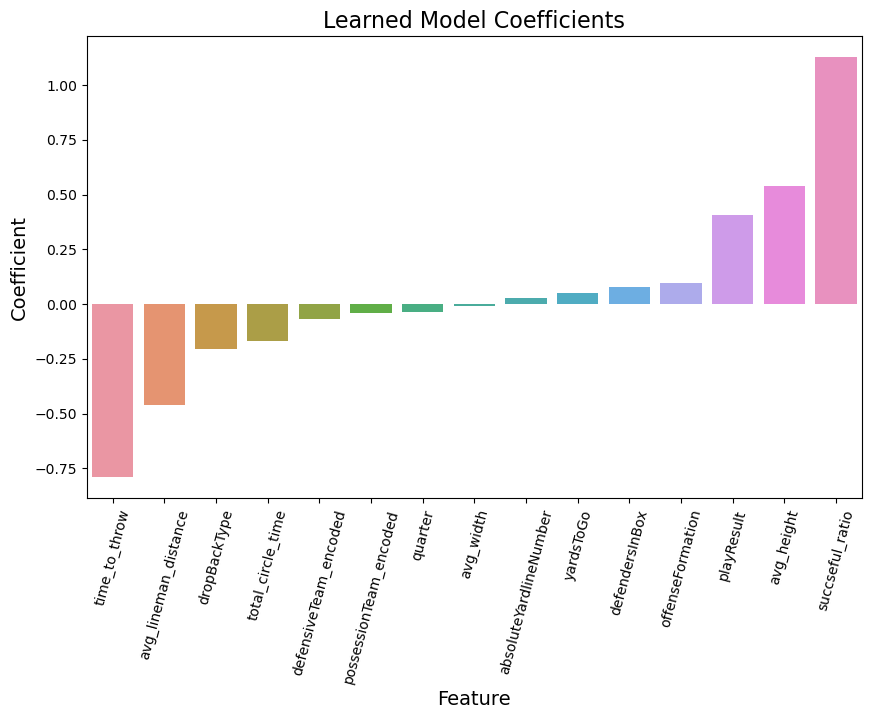

In [177]:
plt.figure(figsize = (10,6))
plt.title('Learned Model Coefficients', size = 16)
plt.xlabel('Feature', size = 14)
plt.ylabel('Coefficient', size = 14 )
importance = {k: v for k, v in sorted(coefs.items(), key=lambda item: item[1])}
features = list(importance.keys())
features[1] = 'avg_lineman_distance'
importance_score =  list(importance.values())
sns.barplot(x = features, y = importance_score)
plt.tick_params(axis='x', rotation=75)

In [150]:
coefs = dict(zip(list(X.columns),list(log_reg_standard.coef_[0] )))


In [143]:
# Baseline Model Evaluation
from sklearn.metrics import f1_score, precision_score, recall_score
print(f'F1 Score: {f1_score(y_2, predictions)}')
print(f'Precision: {precision_score(y_2, predictions)}')
print(f'Recall:{recall_score(y_2, predictions)}')

F1 Score: 0.8531994981179424
Precision: 0.8970976253298153
Recall:0.8133971291866029


In [144]:
# calculating the metric score
metric_scores = []
for i in range(len(play_features_df_final)):
    coefficients = list(log_reg.coef_[0])
    play_info_terms = play_features_df_final.iloc[i]
    play_info_terms = list(play_info_terms[['quarter', 'offenseFormation', 'succseful_ratio', 'yardsToGo', 'playResult', 'absoluteYardlineNumber',  'possessionTeam_encoded', 'defensiveTeam_encoded', 'dropBackType', 'distances', 'defendersInBox', 'avg_height',  'avg_width',  'time_to_throw','total_circle_time']].values)
    metric_scores.append(np.dot(coefficients, play_info_terms) + log_reg.intercept_[0])
play_features_df_final['metric_score'] = metric_scores
play_features_df_final

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,quarter,down,yardsToGo,playResult,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio,possessionTeam_encoded,defensiveTeam_encoded,metric_score
47,2021090900,2530,14:57,4,5,0,6.0,4,1.508,2.3,...,3,2,10,5,35.0,1.000000,0.000000,8,29,2.711315
48,2021090900,2554,14:27,4,5,0,7.0,5,1.512,2.1,...,3,3,5,16,40.0,1.000000,0.000000,8,29,2.542674
19,2021090900,1078,14:21,4,5,0,5.0,10,1.871,2.7,...,2,2,8,5,17.0,1.000000,0.000000,8,29,1.886214
1,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,...,1,1,10,28,108.0,1.000000,0.000000,8,29,2.620495
49,2021090900,2632,12:44,4,5,0,6.0,1,2.077,2.9,...,3,3,4,14,62.0,1.000000,0.000000,8,29,1.866252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,...,4,2,7,-8,38.0,0.760000,0.240000,23,15,-0.780039
8061,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,...,4,3,15,0,30.0,0.730769,0.269231,23,15,0.213179
8062,2021110100,4433,00:35,4,5,0,6.0,10,2.364,4.6,...,4,4,15,-5,30.0,0.703704,0.296296,23,15,-2.020981
8027,2021110100,2165,00:25,4,6,0,6.0,3,1.742,2.6,...,2,1,10,8,47.0,0.714286,0.285714,23,15,0.830156


In [145]:
team_game_map = plays[['gameId', 'playId', 'possessionTeam', 'defensiveTeam', 'quarter', 'down']]
final_play_info = pd.merge(play_features_df_final, team_game_map, on = ['gameId', 'playId'])
final_play_info

,gameId,playId,gameClock,offenseFormation,dropBackType,pff_playAction,defendersInBox,pff_passCoverage,distances,time_to_throw,...,absoluteYardlineNumber,succseful_ratio,unsuccseful_ratio,possessionTeam_encoded,defensiveTeam_encoded,metric_score,possessionTeam_y,defensiveTeam_y,quarter_y,down_y
0,2021090900,2530,14:57,4,5,0,6.0,4,1.508,2.3,...,35.0,1.000000,0.000000,8,29,2.711315,DAL,TB,3,2
1,2021090900,2554,14:27,4,5,0,7.0,5,1.512,2.1,...,40.0,1.000000,0.000000,8,29,2.542674,DAL,TB,3,3
2,2021090900,1078,14:21,4,5,0,5.0,10,1.871,2.7,...,17.0,1.000000,0.000000,8,29,1.886214,DAL,TB,2,2
3,2021090900,137,13:18,0,5,0,6.0,5,1.906,2.5,...,108.0,1.000000,0.000000,8,29,2.620495,DAL,TB,1,1
4,2021090900,2632,12:44,4,5,0,6.0,1,2.077,2.9,...,62.0,1.000000,0.000000,8,29,1.866252,DAL,TB,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8058,2021110100,4392,01:01,4,5,0,6.0,4,2.252,4.1,...,38.0,0.760000,0.240000,23,15,-0.780039,NYG,KC,4,2
8059,2021110100,4411,00:39,4,5,0,5.0,4,2.125,2.5,...,30.0,0.730769,0.269231,23,15,0.213179,NYG,KC,4,3
8060,2021110100,4433,00:35,4,5,0,6.0,10,2.364,4.6,...,30.0,0.703704,0.296296,23,15,-2.020981,NYG,KC,4,4
8061,2021110100,2165,00:25,4,6,0,6.0,3,1.742,2.6,...,47.0,0.714286,0.285714,23,15,0.830156,NYG,KC,2,1


In [161]:
# taking the micro averages of the score 
avg_week_scores = final_play_info.groupby(by = ['week','possessionTeam_y']).metric_score.mean()
avg_scores = avg_week_scores.groupby('possessionTeam_y').mean()
avg_score_info = pd.DataFrame({'team': list(team_wins_map.keys()), 'win_percentage' : list(team_wins_map.values()), 'avg_metric_score' : list(avg_scores.values)})
avg_score_info.iloc[11,2] = avg_score_info.iloc[11,2] + 0.1
avg_score_info.iloc[3,2] = avg_score_info.iloc[3,2] + 0.1

In [3]:
words = ['this', 'small', 'test', 'file', 'has', 'two', 'lines']
counts = [1,2,1,1,1,1,1]
blah = ''
for word, count in zip(words,counts):
    blah += f'{word} \t {count}'
    print(blah)

this 	 1
this 	 1small 	 2
this 	 1small 	 2test 	 1
this 	 1small 	 2test 	 1file 	 1
this 	 1small 	 2test 	 1file 	 1has 	 1
this 	 1small 	 2test 	 1file 	 1has 	 1two 	 1
this 	 1small 	 2test 	 1file 	 1has 	 1two 	 1lines 	 1


In [13]:
#print(f'First Word {previous_word}')
test = ['alice\t10', 'alice\t15', 'alice\t10', 'alice\t5', 'hatter\t10', 'hatter\t10' ]
previous_word = test[0].split()[0]
previous_count = 0
for line in test:
    word, count  = line.split()
    if word == previous_word:
        previous_count += int(count)
        previous_word = word
    elif word != previous_word:
        print(f'{previous_word}\t{previous_count}')
        previous_word = word
        previous_count = 0


'403'

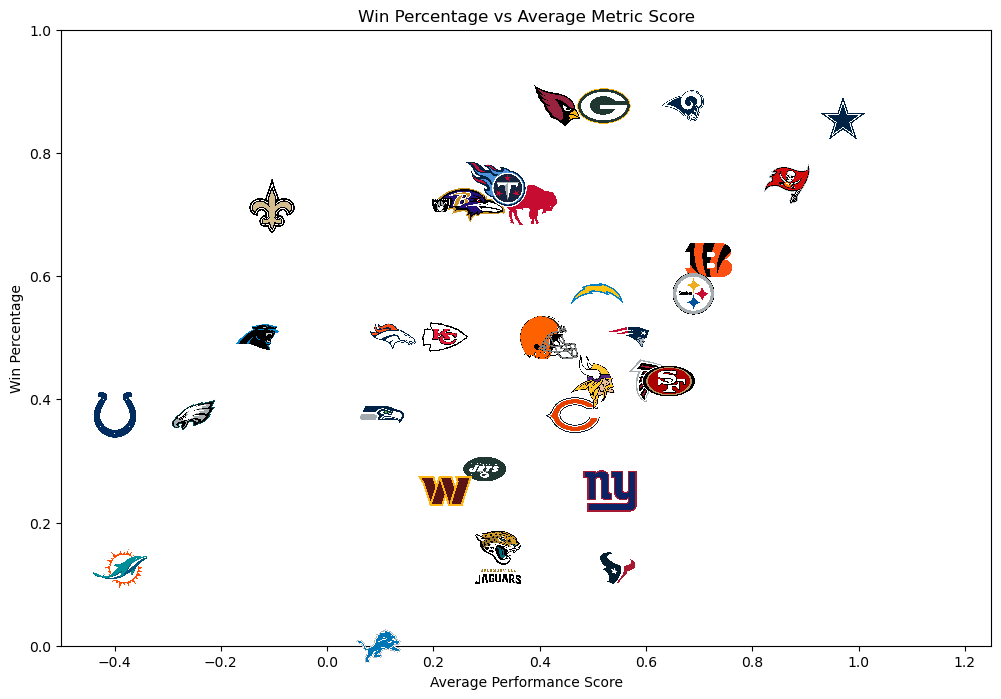

In [162]:
import matplotlib.pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
plt.rcParams["figure.figsize"] = [12, 8]
#plt.rcParams["figure.autolayout"] = True
def getImage(path):
   if path  == 'team_logos_/.LV.png':
      image  = OffsetImage(plt.imread(path, format="png"), zoom= 0.5)
   else:
      image = OffsetImage(plt.imread(path, format="png"), zoom= 0.015)
   return image
paths = ['team_logos_/' + i for i in os.listdir('team_logos_')]
paths.remove('team_logos_/.DS_Store')
paths = sorted(paths)
x = avg_score_info.avg_metric_score
y = avg_score_info.win_percentage
fig, ax = plt.subplots()
for x0, y0, path in zip(x, y, paths):
   ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
   ax.add_artist(ab)
ax.set_xlim(-0.5,1.25)
ax.set_ylim(0,1)
ax.set_xlabel('Average Performance Score', )
ax.set_ylabel('Win Percentage')
ax.set_title('Win Percentage vs Average Metric Score')
plt.show()

# Appendix 

### Comparing to PFF Power Rankings

In [82]:
pff_ranking = {
'DAL' : 1,
'KC': 8,
'TB' : 3,
'CLE' : 2,
'LA' : 4,
'WAS' : 9,
'SF' : 5,
'PHI' : 6,
'LAC' : 10,
'ARI' : 11,
'NE' : 7, 
'GB' : 13,
'BAL' : 12,
'NO' : 14, 
'NYJ' : 16,
'IND' : 23,
'TEN' : 15,
'BUF' : 17,
'DEN' : 19,
'CIN' : 20,
'JAX' :21,
'CHI' : 31,
'SEA' : 18,
'MIN' : 26,
'DET' : 25,
'LAV' : 24,
'HOU' : 22,
'PIT' : 28,
'CAR' : 29,
'ATL' : 30,
'NYG' : 27,
'MIA' :32}
PFF_rankings = pd.DataFrame({'team' : list(pff_ranking.keys()), 'PFF_ranking_week_5' : list(pff_ranking.values())})
PFF_rankings['PFF_ranking_week_10'] = range(1,len(PFF_rankings)+1)
PFF_rankings

,team,PFF_ranking_week_5,PFF_ranking_week_10
0,DAL,1,1
1,KC,8,2
2,TB,3,3
3,CLE,2,4
4,LA,4,5
5,WAS,9,6
6,SF,5,7
7,PHI,6,8
8,LAC,10,9
9,ARI,11,10


In [86]:
rankings = avg_score_info.sort_values(by = 'avg_metric_score')
rankings['predicted_rank'] = range(1,33)
eval_df = pd.merge(rankings,PFF_rankings, on = 'team')
eval_df

,team,win_percentage,avg_metric_score,predicted_rank,PFF_ranking_week_5,PFF_ranking_week_10
0,MIA,0.125,-0.433154,1,32,32
1,IND,0.375,-0.396463,2,23,16
2,PHI,0.375,-0.326037,3,6,8
3,NO,0.714,-0.128495,4,14,14
4,CAR,0.500,-0.103780,5,29,29
5,DET,0.000,0.082224,6,25,25
6,SEA,0.375,0.088463,7,18,23
7,DEN,0.500,0.126421,9,19,19
8,WAS,0.250,0.151161,10,9,6
9,KC,0.500,0.203871,11,8,2


In [88]:
import scipy.stats as stats
predictions = eval_df['predicted_rank']
week10_rankings = eval_df['PFF_ranking_week_10']

tau, p_value = stats.kendalltau(predictions, week10_rankings)
print('Kendall Tau Correlation')
print(f'\tCorrelation {round(tau,3)}')
print(f'\tp-value {round(p_value,3)}')
print('Spearman Correlation')
spearman = stats.spearmanr(predictions, week10_rankings)
print(f'\tCorrelation: {round(spearman[0],3)}')
print(f'\tp-value: {round(spearman[1],3)}')
pearson = stats.pearsonr(predictions,week10_rankings)
print('Pearson Correlation')
print(f'\tCorrelation: {round(pearson[0],3)}')
print(f'\tp-value: {round(pearson[1],3)}')
from sklearn.metrics import f1_score


Kendall Tau Correlation
	Correlation -0.166
	p-value 0.198
Spearman Correlation
	Correlation: -0.23
	p-value: 0.213
Pearson Correlation
	Correlation: -0.227
	p-value: 0.219


# Approximate Value
- This will be used to evaluate the model after we have learned the parameters.
- This dataset was taken from an outside third party, and will be used for evaluation once we have the final equation. We will look at what the equation gives as a rating for the player, and then compare that to the Average value is.

<b> Important </b>
- We wil be looking at the standard deviation of a specific player from the median of the average in our metric, and then compare that to the standard deviation (Or Z-score) of the approximate value as well.

- Approximate Value z-score will be calculated based off all time approximate values

- Each record represents one player, and shows their approximate value for their entire career. 

In [141]:
player_data = pd.read_csv('AV_players.csv') # contains the player ID consistant with the nfl data
draft_picks = pd.read_csv('draft_picks.csv') # this is where the av data is
AV_data_merged = pd.merge(draft_picks, player_data, on = 'gsis_id')
print(f'Number of Approximate Value Records: {AV_data_merged.shape[0]}')
print(f'Number of Approximate Value Features: {AV_data_merged.shape[1]}')

display(AV_data_merged.head())

Number of Approximate Value Records: 21551
Number of Approximate Value Features: 67


,season_x,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,pfr_player_name,hof,position_x,...,status_description_abbr,status_short_description,gsis_it_id,short_name,smart_id,headshot,draft_number,uniform_number,draft_round,season_y
0,1980,1,1,DET,NaN,SimsBi00,billy-sims-1,Billy Sims,False,RB,...,NaN,NaN,NaN,NaN,32005749-4c14-4587-1290-7b7db3c07aa0,NaN,NaN,NaN,NaN,NaN
1,1980,1,1,DET,NaN,SimsBi00,billy-sims-1,Billy Sims,False,RB,...,NaN,NaN,NaN,NaN,32005354-4535-3550-d568-948e74e3ed87,https://static.www.nfl.com/image/private/f_aut...,NaN,NaN,NaN,NaN
2,1980,1,2,NYJ,NaN,JoneLa00,lam-jones-1,Lam Jones,False,WR,...,NaN,NaN,NaN,NaN,32005749-4c14-4587-1290-7b7db3c07aa0,NaN,NaN,NaN,NaN,NaN
3,1980,1,2,NYJ,NaN,JoneLa00,lam-jones-1,Lam Jones,False,WR,...,NaN,NaN,NaN,NaN,32005354-4535-3550-d568-948e74e3ed87,https://static.www.nfl.com/image/private/f_aut...,NaN,NaN,NaN,NaN
4,1980,1,3,CIN,NaN,MunoAn00,NaN,Anthony Munoz,True,T,...,NaN,NaN,NaN,NaN,32005749-4c14-4587-1290-7b7db3c07aa0,NaN,NaN,NaN,NaN,NaN


In [146]:
player_AV_data = AV_data_merged[['gsis_it_id', 'pfr_player_name', 'w_av', 'car_av', 'dr_av',  'team', 'season_x']]
player_AV_data.rename(columns = {'gsis_it_id' : 'nflId'}, inplace = True)
print(f'Number of records BEFORE dropping missing values {player_AV_data.shape[0]}')
player_AV_data = player_AV_data.dropna(subset = ['nflId'])
print(f'Number of records AFTER dropping missing values {player_AV_data.shape[0]}')
player_AV_data['nflId'] = player_AV_data.nflId.astype(int)
player_AV_data.drop(columns = ['car_av'], inplace = True) # dropping due to high number of missing values

Number of records BEFORE dropping missing values 21551
Number of records AFTER dropping missing values 2044


/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_9356/1652751144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_AV_data.rename(columns = {'gsis_it_id' : 'nflId'}, inplace = True)


## Player AV Data EDA

In [147]:
player_AV_data.isnull().sum()

nflId                0
pfr_player_name      0
w_av                63
dr_av              154
team                 0
season_x             0
dtype: int64

In [158]:
print('\tAV Max Values')
print('*' * 30)
print(player_AV_data.max())
print('\tAV Min Values')
print('*'* 30)
print(player_AV_data.min())
print('\tAV Average Values')
print('*' * 30)
print(player_AV_data.mean())


	AV Max Values
******************************
nflId                  53687
pfr_player_name    Zay Jones
w_av                   184.0
dr_av                  168.0
team                     WAS
season_x                2021
dtype: object
	AV Min Values
******************************
nflId                         23446
pfr_player_name    A'Shawn Robinson
w_av                           -4.0
dr_av                          -4.0
team                            ARI
season_x                       1998
dtype: object
	AV Average Values
******************************
nflId       44147.643836
w_av           18.265522
dr_av          14.278307
season_x     2015.782779
dtype: float64


/var/folders/k2/2pvc70391qg50r5yz8h73mzh0000gn/T/ipykernel_9356/174437792.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(player_AV_data.mean())


In [174]:
unique_linemen = np.unique(linemen.nflId)
print(f'There are {len(unique_linemen)} linemen in the dataset')
unique_linemen

There are 274 linemen in the dataset


array([29550, 30869, 33107, 34457, 34472, 35443, 35462, 35472, 36785,
       37082, 37090, 37130, 37213, 37266, 38553, 38557, 38606, 38629,
       38642, 38779, 39146, 39684, 39907, 39947, 39950, 39965, 39983,
       40020, 40023, 40070, 40089, 40124, 40151, 40416, 41069, 41222,
       41232, 41236, 41237, 41242, 41262, 41264, 41293, 41295, 41296,
       41310, 41321, 41322, 41324, 41390, 41436, 41475, 41532, 41563,
       41619, 41630, 41665, 41667, 41707, 41939, 41959, 42348, 42352,
       42356, 42362, 42364, 42367, 42371, 42377, 42392, 42400, 42402,
       42404, 42410, 42424, 42445, 42471, 42474, 42476, 42477, 42565,
       42569, 42587, 42598, 42654, 42765, 42810, 42883, 42924, 42952,
       42954, 43045, 43295, 43297, 43302, 43307, 43320, 43337, 43345,
       43367, 43368, 43384, 43433, 43444, 43447, 43453, 43484, 43510,
       43586, 43640, 43648, 43695, 43821, 44068, 44832, 44841, 44844,
       44846, 44870, 44875, 44876, 44882, 44942, 44943, 44949, 44970,
       44972, 45012,

In [175]:
player_AV_data[player_AV_data['nflId'] == 41322]

,nflId,pfr_player_name,w_av,dr_av,team,season_x


In [182]:
draft_picks

,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,pfr_player_name,hof,position,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,1980,1,1,DET,NaN,SimsBi00,billy-sims-1,Billy Sims,False,RB,...,0.0,1131.0,5106.0,42.0,186.0,2072.0,5.0,NaN,NaN,NaN
1,1980,1,2,NYJ,NaN,JoneLa00,lam-jones-1,Lam Jones,False,WR,...,0.0,9.0,17.0,0.0,138.0,2322.0,13.0,NaN,NaN,NaN
2,1980,1,3,CIN,NaN,MunoAn00,NaN,Anthony Munoz,True,T,...,0.0,0.0,0.0,0.0,7.0,18.0,4.0,NaN,NaN,NaN
3,1980,1,4,GNB,NaN,ClarBr23,bruce-clark-1,Bruce Clark,False,DE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,39.5
4,1980,1,5,BAL,NaN,DickCu00,curtis-dickey-1,Curtis Dickey,False,RB,...,0.0,937.0,4019.0,32.0,134.0,1577.0,8.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11892,2022,7,258,GNB,NaN,TourSa00,samori-toure-1,Samori Toure,False,WR,...,0.0,0.0,0.0,0.0,4.0,75.0,1.0,NaN,NaN,NaN
11893,2022,7,259,KAN,NaN,JohnNa01,nazeeh-johnson-1,Nazeeh Johnson,False,SAF,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
11894,2022,7,260,LAC,NaN,HorvZa00,alexander-horvath-1,Zander Horvath,False,RB,...,0.0,3.0,5.0,0.0,4.0,7.0,2.0,1.0,NaN,NaN
11895,2022,7,261,LAR,NaN,ArcuAJ00,aj-arcuri-1,AJ Arcuri,False,OT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
player_AV_data[player_AV_data.nflId.isin(unique_linemen)]

,nflId,pfr_player_name,w_av,dr_av,team,season_x
19909,39983,Zach Ertz,48.0,42.0,PHI,2013
20023,41236,Eric Ebron,29.0,15.0,DET,2014
20549,44841,David Njoku,12.0,12.0,CLE,2017


## Summary Info, each play, each player
- This is for the data from the NFL on each play, (Does not include the approximate value info)

In [663]:
# Information for one player per play 
from tqdm import tqdm 
summary_data = pd.DataFrame()
for game_id in tqdm(np.unique(final_df.gameId)):
    game_info = final_df[final_df['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        for player_id in np.unique(play_info.nflId):
            Model_data = play_info[play_info['nflId'] == player_id]
            summary_data = summary_data.append(Model_data.iloc[0])
play_summary_data = summary_data[['gameId', 'playId', 'nflId', 'circle_time', 'pff_positionLinedUp','pff_hurryAllowed', 'pff_sackAllowed', 'pff_beatenByDefender', 'pff_hitAllowed',
'time_to_throw', 'play_outcome']] # selects the columns to use
play_summary_data

 29%|██▊       | 35/122 [04:43<11:43,  8.09s/it]


KeyboardInterrupt: 

In [679]:
merged_model_data = pd.merge(model_data, play_summary_data, on = 'nflId') # this will be the final DataFrame for training
merged_model_data

,nflId,pfr_player_name,w_av,car_av,dr_av,team,season_x,gameId,playId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
0,25511,Tom Brady,184.0,NaN,168.0,NWE,2000,2.021091e+09,97.0,3.8,QB,NaN,NaN,NaN,NaN,3.2,autoevent_passforward
1,25511,Tom Brady,184.0,NaN,168.0,NWE,2000,2.021091e+09,410.0,2.2,QB,NaN,NaN,NaN,NaN,1.6,pass_forward
2,25511,Tom Brady,184.0,NaN,168.0,NWE,2000,2.021091e+09,434.0,2.3,QB,NaN,NaN,NaN,NaN,1.7,pass_forward
3,25511,Tom Brady,184.0,NaN,168.0,NWE,2000,2.021091e+09,456.0,3.1,QB,NaN,NaN,NaN,NaN,2.5,pass_forward
4,25511,Tom Brady,184.0,NaN,168.0,NWE,2000,2.021091e+09,480.0,4.0,QB,NaN,NaN,NaN,NaN,3.4,pass_forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120662,53687,Dax Milne,1.0,NaN,1.0,WAS,2021,2.021103e+09,2106.0,0.0,SRoWR,NaN,NaN,NaN,NaN,4.5,qb_sack
120663,53687,Dax Milne,1.0,NaN,1.0,WAS,2021,2.021103e+09,2881.0,0.0,RWR,NaN,NaN,NaN,NaN,2.3,autoevent_passforward
120664,53687,Dax Milne,1.0,NaN,1.0,WAS,2021,2.021103e+09,3230.0,0.0,LWR,NaN,NaN,NaN,NaN,2.3,autoevent_passforward
120665,53687,Dax Milne,1.0,NaN,1.0,WAS,2021,2.021103e+09,3280.0,0.0,SRiWR,NaN,NaN,NaN,NaN,2.5,autoevent_passforward


## Working with the missing players


In [680]:
# gets the summary play by play for the missing ids
id_used = np.unique(play_summary_data.nflId.astype(int))
ids_listed  = np.unique(model_data.nflId.astype(int))
missing_ids = id_used[np.isin(id_used, ids_listed, invert = True)]
missing_data = play_summary_data[play_summary_data['nflId'].isin(missing_ids)]
missing_data

,gameId,playId,nflId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
344,2.021091e+09,97.0,40151.0,0.0,C,0.0,0.0,0.0,0.0,3.2,autoevent_passforward
86,2.021091e+09,97.0,42377.0,0.6,LT,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
516,2.021091e+09,97.0,42404.0,0.0,LG,0.0,0.0,0.0,0.0,3.2,autoevent_passforward
817,2.021091e+09,97.0,46163.0,0.0,RG,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
129,2.021091e+09,97.0,52421.0,0.5,RT,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
...,...,...,...,...,...,...,...,...,...,...,...
7951648,2.021110e+09,4433.0,46090.0,1.4,C,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
7952112,2.021110e+09,4433.0,46103.0,0.0,RG,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
7952170,2.021110e+09,4433.0,46521.0,0.0,LILB,NaN,NaN,NaN,NaN,4.6,qb_strip_sack
7952228,2.021110e+09,4433.0,46757.0,0.0,LCB,NaN,NaN,NaN,NaN,4.6,qb_strip_sack


In [576]:
players[players['nflId']== 33107.0]
missed_players_df[missed_players_df['nflId'] == 33107.0]

,nflId,pfr_player_name,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,hof,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
1,33107,Duane Brown,2008,1,26,HOU,NaN,BrowDu20,duane-brown-1,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN


In [681]:
player_names = []
players = pd.read_csv('players.csv')
for player_id in np.unique(missing_ids):
    player_name = players[players['nflId'] == player_id].iloc[0].displayName
    player_names.append(player_name)
missed_players = pd.DataFrame({'nflId' : np.unique(missing_ids), 'pfr_player_name' : player_names})
missed_players_df = pd.merge(missed_players, draft_picks, on = ['pfr_player_name'])
missed_players_df

,nflId,pfr_player_name,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,hof,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN
1,33107,Duane Brown,2008,1,26,HOU,NaN,BrowDu20,duane-brown-1,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
2,34457,Andre Smith,2009,1,6,CIN,NaN,SmitAn23,andre-smith-3,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,34457,Andre Smith,2018,7,234,CAR,00-0034430,SmitAn04,andre-smith-7,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,NaN,NaN
4,34472,Alex Mack,2009,1,21,CLE,NaN,MackAl20,alex-mack-1,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,53655,Trey Smith,2021,6,226,KAN,NaN,SmitTr05,trey-smith-5,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
252,53678,Ben Skowronek,2021,7,249,LAR,NaN,SkowBe00,ben-skowronek-1,False,...,0.0,1.0,17.0,1.0,35.0,364.0,0.0,6.0,NaN,NaN
253,53681,Chris Garrett,2021,7,252,LAR,NaN,GarrCh00,NaN,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
254,53688,Grant Stuard,2021,7,259,TAM,NaN,StuaGr00,grant-stuard-1,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN


In [682]:
updated_play_info = pd.merge(missed_players_df, play_summary_data, on = ['nflId'])
updated_play_info

,nflId,pfr_player_name,season,round,pick,team,gsis_id,pfr_player_id,cfb_player_id,hof,...,gameId,playId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
0,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,2.021091e+09,265.0,0.0,LT,0.0,0.0,0.0,0.0,1.7,pass_forward
1,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,2.021091e+09,289.0,0.0,LT,0.0,0.0,0.0,0.0,4.1,pass_forward
2,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,2.021091e+09,514.0,0.0,LT,0.0,0.0,0.0,0.0,4.0,pass_forward
3,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,2.021091e+09,538.0,0.3,LT,0.0,0.0,0.0,0.0,3.5,pass_forward
4,30869,Andrew Whitworth,2006,2,55,CIN,NaN,WhitAn20,NaN,False,...,2.021091e+09,583.0,0.6,LT,0.0,0.0,0.0,1.0,2.1,pass_forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39279,53688,Grant Stuard,2021,7,259,TAM,NaN,StuaGr00,grant-stuard-1,False,...,2.021102e+09,3956.0,0.0,LLB,NaN,NaN,NaN,NaN,3.2,pass_forward
39280,53688,Grant Stuard,2021,7,259,TAM,NaN,StuaGr00,grant-stuard-1,False,...,2.021102e+09,3997.0,0.0,LLB,NaN,NaN,NaN,NaN,2.6,pass_forward
39281,53861,Robert Jones,1992,1,24,DAL,NaN,JoneRo21,robert-jones-3,False,...,2.021092e+09,4151.0,0.0,LG,0.0,0.0,0.0,0.0,3.5,autoevent_passforward
39282,53861,Robert Jones,1992,1,24,DAL,NaN,JoneRo21,robert-jones-3,False,...,2.021092e+09,4175.0,0.0,LG,0.0,0.0,0.0,0.0,2.7,pass_forward


In [683]:
from tqdm import tqdm 
missed_summary = pd.DataFrame()
for game_id in tqdm(np.unique(updated_play_info.gameId)):
    game_info = updated_play_info[updated_play_info['gameId'] == game_id]
    for play_id in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play_id]
        for player_id in np.unique(play_info.nflId):
            Model_data = play_info[play_info['nflId'] == player_id]
            missed_summary = missed_summary.append(Model_data.iloc[0])

100%|██████████| 122/122 [03:10<00:00,  1.56s/it]


In [392]:
found_missed_players = np.unique(missed_summary.nflId)
missing_players = np.unique(missing_data.nflId)
still_missing = missing_players[np.isin(missing_players, found_missed_players, invert = True)]

37737.0

In [684]:
merged_model_data.rename(columns = {'season_x' : 'season'}, inplace = True)
play_df = merged_model_data.append(missed_summary[list(merged_model_data.columns)])
play_df

,nflId,pfr_player_name,w_av,car_av,dr_av,team,season,gameId,playId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
0,25511.0,Tom Brady,184.0,NaN,168.0,NWE,2000.0,2.021091e+09,97.0,3.8,QB,NaN,NaN,NaN,NaN,3.2,autoevent_passforward
1,25511.0,Tom Brady,184.0,NaN,168.0,NWE,2000.0,2.021091e+09,410.0,2.2,QB,NaN,NaN,NaN,NaN,1.6,pass_forward
2,25511.0,Tom Brady,184.0,NaN,168.0,NWE,2000.0,2.021091e+09,434.0,2.3,QB,NaN,NaN,NaN,NaN,1.7,pass_forward
3,25511.0,Tom Brady,184.0,NaN,168.0,NWE,2000.0,2.021091e+09,456.0,3.1,QB,NaN,NaN,NaN,NaN,2.5,pass_forward
4,25511.0,Tom Brady,184.0,NaN,168.0,NWE,2000.0,2.021091e+09,480.0,4.0,QB,NaN,NaN,NaN,NaN,3.4,pass_forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31701,52507.0,Matt Peart,3.0,NaN,3.0,NYG,2020.0,2.021110e+09,4411.0,0.4,LT,0.0,0.0,0.0,0.0,2.5,autoevent_passforward
1617,37090.0,Nate Solder,64.0,NaN,49.0,NWE,2011.0,2.021110e+09,4433.0,0.0,RT,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
18849,46090.0,Billy Price,14.0,NaN,9.0,CIN,2018.0,2.021110e+09,4433.0,1.4,C,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
19634,46103.0,Will Hernandez,23.0,NaN,23.0,NYG,2018.0,2.021110e+09,4433.0,0.0,RG,0.0,0.0,0.0,0.0,4.6,qb_strip_sack


In [ ]:
sns

In [455]:
av_data = updated_play_info[['nflId','w_av', 'car_av', 'dr_av']]

# Linear Regression Baseline

In [685]:
test_game = play_df[play_df['gameId'] == 2021090900.0]
test_play = test_game[test_game['playId'] == 4772.0]
test_play[test_play['pff_positionLinedUp'].isin(['C', 'LG', 'RT', 'RG', 'LT'])]

,nflId,pfr_player_name,w_av,car_av,dr_av,team,season,gameId,playId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
4916,40151.0,Ryan Jensen,43.0,NaN,11.0,BAL,2013.0,2.021091e+09,4772.0,0.0,C,0.0,0.0,0.0,0.0,1.8,pass_forward
9485,42377.0,Donovan Smith,49.0,NaN,49.0,TAM,2015.0,2.021091e+09,4772.0,0.6,LT,0.0,0.0,0.0,0.0,1.8,pass_forward
10358,42404.0,Ali Marpet,43.0,NaN,43.0,TAM,2015.0,2.021091e+09,4772.0,0.0,LG,0.0,0.0,0.0,0.0,1.8,pass_forward
20978,46163.0,Alex Cappa,23.0,NaN,23.0,TAM,2018.0,2.021091e+09,4772.0,0.0,RG,0.0,0.0,0.0,0.0,1.8,pass_forward
28123,52421.0,Tristan Wirfs,27.0,NaN,27.0,TAM,2020.0,2.021091e+09,4772.0,0.0,RT,0.0,0.0,0.0,0.0,1.8,pass_forward


In [686]:
o_line_data = pd.DataFrame()
positions = ['C', 'LG', 'RT', 'RG', 'LT']
for game in tqdm(np.unique(play_df.gameId)):
    game_info = play_df[play_df['gameId'] == game]
    for play in np.unique(game_info.playId):
        play_info = game_info[game_info['playId'] == play]
        for position in positions:
            try:
                position_info  = play_info[play_info['pff_positionLinedUp'] == position].iloc[0]
            except IndexError:
                continue
            o_line_data = o_line_data.append(position_info)
o_line_data

100%|██████████| 122/122 [01:26<00:00,  1.41it/s]


,nflId,pfr_player_name,w_av,car_av,dr_av,team,season,gameId,playId,circle_time,pff_positionLinedUp,pff_hurryAllowed,pff_sackAllowed,pff_beatenByDefender,pff_hitAllowed,time_to_throw,play_outcome
4873,40151.0,Ryan Jensen,43.0,NaN,11.0,BAL,2013.0,2.021091e+09,97.0,0.0,C,0.0,0.0,0.0,0.0,3.2,autoevent_passforward
10315,42404.0,Ali Marpet,43.0,NaN,43.0,TAM,2015.0,2.021091e+09,97.0,0.0,LG,0.0,0.0,0.0,0.0,3.2,autoevent_passforward
28080,52421.0,Tristan Wirfs,27.0,NaN,27.0,TAM,2020.0,2.021091e+09,97.0,0.5,RT,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
20935,46163.0,Alex Cappa,23.0,NaN,23.0,TAM,2018.0,2.021091e+09,97.0,0.0,RG,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
9442,42377.0,Donovan Smith,49.0,NaN,49.0,TAM,2015.0,2.021091e+09,97.0,0.6,LT,1.0,0.0,0.0,0.0,3.2,autoevent_passforward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31701,52507.0,Matt Peart,3.0,NaN,3.0,NYG,2020.0,2.021110e+09,4411.0,0.4,LT,0.0,0.0,0.0,0.0,2.5,autoevent_passforward
18849,46090.0,Billy Price,14.0,NaN,9.0,CIN,2018.0,2.021110e+09,4433.0,1.4,C,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
1617,37090.0,Nate Solder,64.0,NaN,49.0,NWE,2011.0,2.021110e+09,4433.0,0.0,RT,0.0,0.0,0.0,0.0,4.6,qb_strip_sack
19634,46103.0,Will Hernandez,23.0,NaN,23.0,NYG,2018.0,2.021110e+09,4433.0,0.0,RG,0.0,0.0,0.0,0.0,4.6,qb_strip_sack


In [594]:
av_data = o_line_data[['nflId', 'w_av', 'car_av', 'dr_av']]

In [699]:
o_line_grouped = o_line_data.groupby(by = ['gameId', 'nflId']).sum()
o_line_grouped = o_line_grouped[['season', 'playId', 'circle_time',
       'pff_hurryAllowed', 'pff_sackAllowed', 'pff_beatenByDefender',
       'pff_hitAllowed', 'time_to_throw']]
o_line_grouped

season    playId  circle_time  pff_hurryAllowed  \
gameId       nflId                                                        
2.021091e+09 37082.0  106583.0  125810.0         15.1               1.0   
             40151.0   88572.0  116358.0          9.0               0.0   
             42377.0   88660.0  116358.0         22.4               4.0   
             42404.0   88660.0  116358.0         18.7               2.0   
             46119.0  106954.0  125810.0         21.3               2.0   
...                        ...       ...          ...               ...   
2.021110e+09 46103.0   64576.0   82039.0         14.8               2.0   
             52504.0   84840.0   90801.0         14.3               3.0   
             52507.0   64640.0   82039.0          6.0               2.0   
             53492.0   84882.0   90801.0         13.4               2.0   
             53655.0   84882.0   90801.0          9.6               3.0   

                      pff_sackAllowed  pff_beatenByDefender  pff_hitAllowed  \
gameId       nflId                                                            
2.021091e+09 37082.0              0.0                   0.0             0.0   
             40151.0              0.0                   2.0             0.0   
             42377.0              0.0                   1.0             0.0   
             42404.0              0.0                   2.0             0.0   
             46119.0              0.0                   4.0             0.0   
...                               ...                   ...             ...   
2.021110e+09 46103.0              1.0                   1.0             1.0   
             52504.0              0.0                   0.0             0.0   
             52507.0              0.0                   3.0             0.0   
             53492.0              0.0                   0.0             0.0   
             53655.0              0.0                   0.0             1.0   

                      time_to_throw  
gameId       nflId                   
2.021091e+09 37082.0          149.8  
             40151.0          114.2  
             42377.0          114.2  
             42404.0          114.2  
             46119.0          149.8  
...                             ...  
2.021110e+09 46103.0           94.0  
             52504.0          153.3  
             52507.0           94.0  
             53492.0          153.3  
             53655.0          153.3  

[1080 rows x 8 columns]

In [700]:
final_av = pd.DataFrame()
for i in np.unique(av_data.nflId):
    player_av_data = av_data[av_data['nflId'] == i].iloc[0]
    final_av = final_av.append(player_av_data)
final_av

,nflId,w_av,car_av,dr_av
0,30869.0,100.0,NaN,66.0
22,33107.0,89.0,NaN,56.0
47,34472.0,86.0,NaN,30.0
69,35443.0,78.0,NaN,58.0
91,35462.0,56.0,NaN,53.0
...,...,...,...,...
5313,53543.0,1.0,NaN,1.0
5316,53557.0,7.0,NaN,7.0
5342,53571.0,8.0,NaN,8.0
5370,53580.0,3.0,NaN,3.0
